In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
train_dir = r"F:\work\python\archive\Training"
test_dir = r"F:\work\python\archive\Testing"

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [8]:
import numpy as np

# Count images per class
class_counts = np.bincount(train_generator.classes)

# Get class names
class_labels = list(train_generator.class_indices.keys())

# Print results
for i, count in enumerate(class_counts):
    print(f"{class_labels[i]}: {count} images")

glioma_tumor: 826 images
meningioma_tumor: 822 images
no_tumor: 395 images
pituitary_tumor: 827 images


In [10]:
class_counts_test = np.bincount(val_generator.classes)
class_labels_test = list(val_generator.class_indices.keys())

for i, count in enumerate(class_counts_test):
    print(f"{class_labels_test[i]}: {count} images")

glioma_tumor: 100 images
meningioma_tumor: 115 images
no_tumor: 105 images
pituitary_tumor: 74 images


In [11]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 96s 1us/step


In [12]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)


In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.5237 - loss: 1.3501 - val_accuracy: 0.5127 - val_loss: 1.2860 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.7111 - loss: 0.7890 - val_accuracy: 0.6142 - val_loss: 1.1887 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7725 - loss: 0.6038 - val_accuracy: 0.6345 - val_loss: 1.1775 - learning_rate: 1.0000e-04
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7920 - loss: 0.5381 - val_accuracy: 0.6497 - val_loss: 1.2023 - learning_rate: 1.0000e-04
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8028 - loss: 0.5248 - val_accuracy: 0.6624 - val_loss: 1.2249 - learning_rate: 1.0000e-04
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.8314 - loss: 0.4472 - val_accuracy: 0.6650 - val_loss: 1.2510 - learning_rate: 1.0000e-04
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8230 

In [16]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.7990 - loss: 0.5397 - val_accuracy: 0.6548 - val_loss: 1.2431 - learning_rate: 1.0000e-05
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8314 - loss: 0.4628 - val_accuracy: 0.6802 - val_loss: 1.2228 - learning_rate: 1.0000e-05
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 230s 3s/step - accuracy: 0.8540 - loss: 0.4183 - val_accuracy: 0.6980 - val_loss: 1.2820 - learning_rate: 1.0000e-05
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.8561 - loss: 0.3893 - val_accuracy: 0.7107 - val_loss: 1.2681 - learning_rate: 3.0000e-06
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.8627 - loss: 0.3642 - val_accuracy: 0.7132 - val_loss: 1.2540 - learning_rate: 3.0000e-06


In [17]:
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)

print(classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 884ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.74      0.23      0.35       100
meningioma_tumor       0.56      0.81      0.66       115
        no_tumor       0.67      0.85      0.75       105
 pituitary_tumor       0.82      0.72      0.76        74

        accuracy                           0.65       394
       macro avg       0.70      0.65      0.63       394
    weighted avg       0.68      0.65      0.63       394



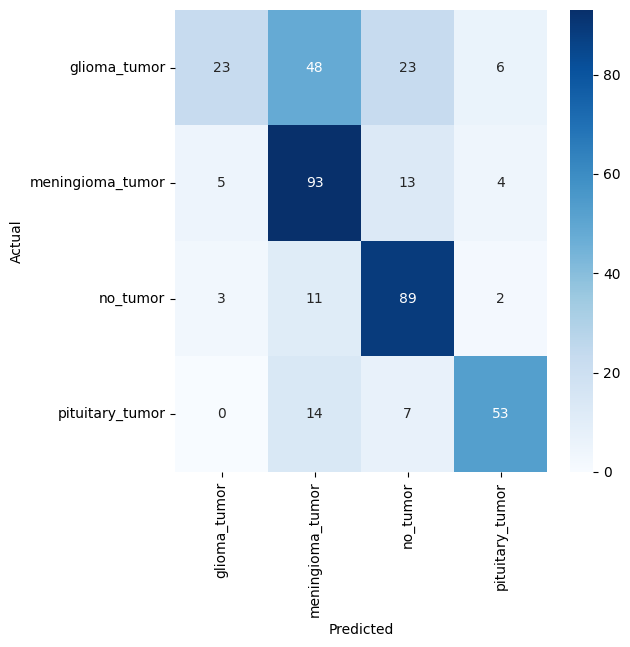

In [18]:
cm = confusion_matrix(val_generator.classes, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [19]:
print("Training samples:", train_generator.samples)
print("Testing samples:", val_generator.samples)


Training samples: 2870
Testing samples: 394
